In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
# from keras.models import Sequential
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
# from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import cv2
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import socket
import sys

from keras.models import load_model, Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed, Dropout, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [ ]:
# GLOBAL VARIABLES
path = "data"
Test_Ratio = 0.2
ValRatio = 0.2
images = []
classid = []
inputShape = (32,32,3)
batchsizeVal = 64
#stepsPerEpochsVal = 200
epochsVal = 50
# img = cv2.imread(path+"/0/IMG_20210613_164138.jpg")
# img.shape

In [ ]:
# to know number and name of the letters in our dataset
#listdir - list of directories
myList = os.listdir(path)
noofclasses = len(myList)
print("No of Classes Detected = ",noofclasses)

print("Importing Classes...")

for x in range(0,noofclasses):
    picList = os.listdir(path+"/"+myList[x])
    for y in picList:
        curImg = cv2.imread(path+"/"+myList[x]+"/"+y)
        curImg = cv2.resize(curImg,(inputShape[0],inputShape[1]))
        images.append(curImg)
        classid.append(x)
    print(x,end=" ")
print(" ")    
print("No of images imported = ",len(images)) 

# To convert into numpy array
images = np.array(images)
classid = np.array(classid)

print(images.shape)
print(classid.shape)

### Splitting the Data


In [ ]:
images

In [ ]:
classid

In [ ]:
classid = classid.reshape(-1, 1)
noOfClasses = classid
onehotencoder = OneHotEncoder()
Y = onehotencoder.fit_transform(classid).toarray()

images, Y = shuffle(images, Y, random_state=69)

x_train, x_test, y_train, y_test = train_test_split(
    images, Y, test_size=0.2, random_state=69)
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, test_size=0.2, random_state=69)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)


### PreProcessing


In [ ]:
def preprocessing(img):
    # img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # img = cv2.equalizeHist(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing,x_train)))
X_test = np.array(list(map(preprocessing,x_test)))
X_validation = np.array(list(map(preprocessing,x_validation)))

# To a depth of one to the images 
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],3)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],3)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],3)
print(X_train.shape)


### Augmenting Images

In [ ]:
# y_train = to_categorical(y_train,noofclasses)
# y_test = to_categorical(y_test,noofclasses)
# y_validation = to_categorical(y_validation,noofclasses)

In [ ]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(x_train)

## VGG16 model



In [ ]:
# Calculate class weights based on the distribution of the training set
class_weights = {}
unique, counts = np.unique(classid, return_counts=True)
total = np.sum(counts)
for i in range(len(unique)):
    class_weights[unique[i]] = total / (len(unique) * counts[i])

In [ ]:
vgg = VGG16(input_shape=inputShape, weights='imagenet', include_top=False)
vgg.input

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(noofclasses, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

In [ ]:
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [15]:
history = model.fit(dataGen.flow(X_train, y_train, batch_size=batchsizeVal),
                    steps_per_epoch=None,
                    epochs=epochsVal,
                    validation_data=(X_validation, y_validation),
                    shuffle=1,
                    class_weight=class_weights,
                    verbose=1)

68/68 [==============================] - 77s 1s/step - loss: 3.3258 - accuracy: 0.1348 - val_loss: 3.3016 - val_accuracy: 0.1555
Epoch 7/50
68/68 [==============================] - 91s 1s/step - loss: 3.3093 - accuracy: 0.1376 - val_loss: 3.2702 - val_accuracy: 0.1527
Epoch 8/50
68/68 [==============================] - 85s 1s/step - loss: 3.2843 - accuracy: 0.1446 - val_loss: 3.3046 - val_accuracy: 0.1453
Epoch 9/50
68/68 [==============================] - 47s 684ms/step - loss: 3.2460 - accuracy: 0.1497 - val_loss: 3.3424 - val_accuracy: 0.1257
Epoch 10/50
68/68 [==============================] - 87s 1s/step - loss: 3.1810 - accuracy: 0.1621 - val_loss: 3.1963 - val_accuracy: 0.1425
Epoch 11/50
68/68 [==============================] - 111s 2s/step - loss: 3.1908 - accuracy: 0.1612 - val_loss: 3.1587 - val_accuracy: 0.1723
Epoch 12/50
68/68 [==============================] - 113s 2s/step - loss: 3.1355 - accuracy: 0.1763 - val_loss: 3.2113 - val_accuracy: 0.1583
Epoch 13/50
68/68 [====

In [16]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss Score = ',score[0])
print('Test Accuracy = ',score[1])

Test Loss Score =  471.1801452636719
Test Accuracy =  0.03129657357931137


In [17]:
# Saving the model
pickle_out = open("model_trained_iitbbs_vgg16.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_10
......vars
.........0
.........1
...layers\conv2d_11
......vars
.........0
.........1
...layers\conv2d_12
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\conv2d_6
......vars
.........0
.........1
...layers\conv2d_7
......vars
.........0
.........1
...layers\conv2d_8
......vars
.........0
.........1
...layers\conv2d_9
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\flatten
......vars
...layers\input_layer
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\max_pooling2d_2
......vars
...layers\max_pooling2d_3
......vars


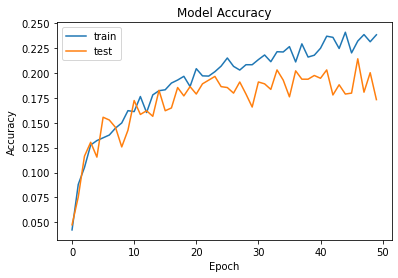

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
